# Customer Segmentation

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

import plotly.offline as pyoff
import plotly.graph_objs as go

pyoff.init_notebook_mode()

In [2]:
df = pd.read_csv("../datasets/OnlineRetail.csv",header=0,encoding = 'unicode_escape')

In [3]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
df.shape

(541909, 8)

### RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
* Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
* High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

In [5]:
#convert the string date field to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [6]:
#we will be using only UK data
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)
df_uk.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

### (1) Calculate recency score

In [9]:
df_user = pd.DataFrame(df['CustomerID'].unique())
df_user.columns = ['CustomerID']

df_max_purchase = df_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

df_user = pd.merge(df_user, df_max_purchase[['CustomerID','Recency']], on='CustomerID')

df_user.head()

CustomerID  Recency
0     17850.0      301
1     13047.0       31
2     13748.0       95
3     15100.0      329
4     15291.0       25

In [11]:
plot_data = [
    go.Histogram(
        x=df_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [12]:
df_user.describe()

CustomerID      Recency
count   3950.000000  3950.000000
mean   15562.029367    90.778481
std     1576.848325   100.230349
min    12346.000000     0.000000
25%    14208.250000    16.000000
50%    15571.500000    49.000000
75%    16913.750000   142.000000
max    18287.000000   373.000000

### Applying K-means clustering to calculate retention score

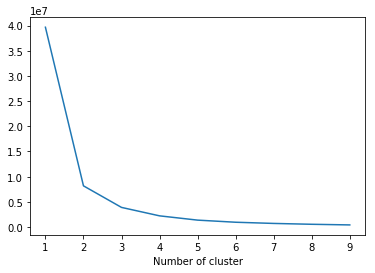

In [13]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [14]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)
df_user.head()

CustomerID  Recency  RecencyCluster
0     17850.0      301               0
1     15100.0      329               0
2     18074.0      373               0
3     16250.0      260               0
4     13747.0      373               0

In [15]:
#get order counts for each user and create a dataframe with it
df_frequency = df_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='CustomerID')

In [16]:
plot_data = [
    go.Histogram(
        x=df_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [18]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])
print(df_user.head())
#order the frequency cluster

df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

   CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster
0     17850.0      301               0        312                 2
1     15808.0      305               0        210                 2
2     13047.0       31               3        196                 2
3     14688.0        7               3        359                 2
4     16029.0       38               3        274                 2


count         mean          std     min     25%     50%  \
FrequencyCluster                                                             
0                 3496.0    49.525744    44.954212     1.0    15.0    33.0   
1                  429.0   331.221445   133.856510   191.0   228.0   287.0   
2                   22.0  1313.136364   505.934524   872.0   988.5  1140.0   
3                    3.0  5917.666667  1805.062418  4642.0  4885.0  5128.0   

                     75%     max  
FrequencyCluster                  
0                   73.0   190.0  
1                  399.0   803.0  
2                 1452.0  2782.0  
3                 6555.5  7983.0

In [19]:
#calculate revenue for each customer
df_uk['Revenue'] = df_uk['UnitPrice'] * df_uk['Quantity']
df_revenue = df_uk.groupby('CustomerID').Revenue.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='CustomerID')

In [20]:
plot_data = [
    go.Histogram(
        x=df_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [21]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'Revenue',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['Revenue'].describe()

count           mean           std        min         25%  \
RevenueCluster                                                               
0               3687.0     907.254414    921.910820   -4287.63     263.115   
1                234.0    7760.699530   3637.173671    4330.67    5161.485   
2                 27.0   43070.445185  15939.249588   25748.35   28865.490   
3                  2.0  221960.330000  48759.481478  187482.17  204721.250   

                      50%         75%        max  
RevenueCluster                                    
0                  572.56    1258.220    4314.72  
1                 6549.38    9142.305   21535.90  
2                36351.42   53489.790   88125.38  
3               221960.33  239199.410  256438.49

In [22]:

#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

Recency    Frequency        Revenue
OverallScore                                        
0             304.584388    21.995781     303.339705
1             185.362989    32.596085     498.087546
2              78.991304    46.963043     868.082991
3              20.689610    68.419590    1091.416414
4              14.892617   271.755034    3607.097114
5               9.662162   373.290541    9136.946014
6               7.740741   876.037037   22777.914815
7               1.857143  1272.714286  103954.025714
8               1.333333  5917.666667   42177.930000

In [23]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [24]:
df_graph = df_user.query("Revenue < 50000 and Frequency < 2000")

In [25]:
plot_data = [
    go.Scatter(
        x=df_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=df_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=df_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'High-Value'")['Frequency'],
        y=df_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [26]:
df_graph = df_user.query("Revenue < 50000 and Frequency < 2000")


In [27]:
plot_data = [
    go.Scatter(
        x=df_graph.query("Segment == 'Low-Value'")['Recency'],
        y=df_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=df_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'High-Value'")['Recency'],
        y=df_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [28]:
df_graph = df_user.query("Revenue < 50000 and Frequency < 2000")


In [29]:
plot_data = [
    go.Scatter(
        x=df_graph.query("Segment == 'Low-Value'")['Recency'],
        y=df_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=df_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'High-Value'")['Recency'],
        y=df_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)